## Empirical Analysis of Similarity Sensitivity in Image Embedding Neighborhoods

Several studies suggest that Approximate Nearest Neighbor (ANN) algorithms substantially reduce the computational expense of a similarity search while maintaining high precision. However, few publications work to directly examime how similarity structure deforms under approzimation as neighborhood size varies. This notebooks conducts an emprical analysis of similarity sensitivity in image embeddings by comparing linear (exact) and approximate nearest neighbor (ANN) searches for varying k-values. 

## Step 1: Project Dependencies
Load all required libraries and verify the computational environment.

### (Optional) Install Dependencies
If the environment has not been initialiaze, install all required packages:

```bash
pip install -r requirements.txt

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
import faiss
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import models
import os 
import json

import numpy as np
from torch.utils.data import Subset


# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("PyTorch version:", torch.__version__)
print("FAISS version:", faiss.__version__)
print("Using device:", device)

PyTorch version: 2.9.1
FAISS version: 1.12.0
Using device: cpu


## Step 2: Experiment Configuration
Define the dataset path, preprocessing pipeline, and hyperparameters used throughout the experiment.

In [2]:
# Path to STL-10 image dataset
DATA_PATH = "./data/stl10-data"

EMB_FILE = "./data/embeddings_resnet50_stl10.npy"
EMB_CHUNK_DIR = "./data/emb_chunks"

# Batch size for embedding extraction
BATCH_SIZE = 32

# Distance metric: euclidean distance
METRIC = "euclidean"

# HNSW parameters
M = 32           # graph connectivity (higher = more accurate, slower)
EF_CONSTRUCTION = 200
EF_SEARCH = 50   # controls ANN accuracy during search

# Data sample size (to deal with computational limits of linear search) 
DATASET_TARGET_SIZE = 10_000 

# Preprocessing pipeline: Transforms/Normalizes images according 
# to the mean and standard deviation of ImageNet.
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# KNN Search Parameters
K_MIN  = 5
K_MAX  = 250
K_STEP = 10

## Step 3: Load Dataset
Load the STL-10 dataset and verify its size, structure, and sample images.

Full STL-10 dataset loaded:
 - Number of samples: 100000
 - Image tensor size: torch.Size([3, 224, 224])

Using subsampled dataset of size: 10000


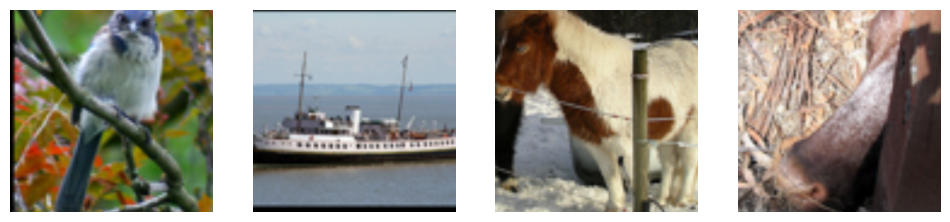

In [3]:
# --- Load STL-10 (100k unlabeled natural images) ---
# We will later subsample to 10k for full linear search feasibility.

dataset = STL10(
    root=DATA_PATH,
    split="unlabeled",      # 100,000 natural images
    download=True,
    transform=transform
)

print("Full STL-10 dataset loaded:")
print(" - Number of samples:", len(dataset))
print(" - Image tensor size:", dataset[0][0].shape)

N = len(dataset)
indices = np.random.choice(N, DATASET_TARGET_SIZE, replace=False)
dataset_10k = Subset(dataset, indices)

print(f"\nUsing subsampled dataset of size: {len(dataset_10k)}")

# --- DataLoader for the 10k dataset ---
loader = DataLoader(
    dataset_10k,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# --- Preview a few samples ---
def show_samples(ds, num=4):
    fig, axes = plt.subplots(1, num, figsize=(12, 3))
    for i in range(num):
        img, _ = ds[i]
        disp = img.permute(1, 2, 0).numpy()
        disp = disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        disp = np.clip(disp, 0, 1)
        axes[i].imshow(disp)
        axes[i].axis("off")
    plt.show()

show_samples(dataset_10k)


## Step 4: Load Pre-trained ResNet-50 Model
Load an ImageNet-trained ResNet-50 and expose its penultimate layer for embedding extraction.

In [4]:
# Load pretrained ResNet-50 (ImageNet-trained weights)
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Remove the final classification layer to expose penultimate embeddings
embedding_model = torch.nn.Sequential(*list(resnet.children())[:-1])
embedding_model.to(device)
embedding_model.eval()

# Embedding extraction function
def extract_embeddings(batch):
    with torch.no_grad():
        feats = embedding_model(batch.to(device))
        # Output shape: (batch_size, 2048, 1, 1) → squeeze to (batch_size, 2048)
        feats = feats.squeeze(-1).squeeze(-1)
    return feats.cpu().numpy().astype("float32")

print("Embedding dimension:", 2048)

Embedding dimension: 2048


## Step 5: Generate Image Embeddings
Extract 2048-dimensional ResNet-50 embeddings for all images, saving batch-level chunks to disk and automatically skipping extraction on future runs if a complete embedding file already exists.

In [5]:
# -------------------------------------------------------
# 1. If the final embedding file exists, load & skip work
# -------------------------------------------------------
if os.path.exists(EMB_FILE):
    print(f"Embeddings already exist → loading {EMB_FILE}")
    embeddings = np.load(EMB_FILE)
    print("Loaded:", embeddings.shape)
    skip_embedding = True
else:
    skip_embedding = False

# -------------------------------------------------------
# 2. Otherwise, extract embeddings batch-by-batch and save
# -------------------------------------------------------
if not skip_embedding:
    print("No saved embeddings found → generating now...")
    os.makedirs(EMB_CHUNK_DIR, exist_ok=True)

    chunk_paths = []
    chunk_id = 0

    for batch, _ in tqdm(loader):
        emb = extract_embeddings(batch)        # (batch, 2048)
        chunk_path = os.path.join(EMB_CHUNK_DIR, f"chunk_{chunk_id}.npy")
        np.save(chunk_path, emb.astype("float32"))
        chunk_paths.append(chunk_path)
        chunk_id += 1

    print(f"Saved {len(chunk_paths)} chunks. Stitching...")

    # Stitch all chunks into the final embedding array
    all_chunks = [np.load(p) for p in chunk_paths]
    embeddings = np.vstack(all_chunks).astype("float32")

    np.save(EMB_FILE, embeddings)
    print(f"Final embedding matrix saved → {EMB_FILE}")
    print("Shape:", embeddings.shape)

print("Embeddings ready for downstream analysis.")


No saved embeddings found → generating now...


100%|██████████| 313/313 [15:33<00:00,  2.98s/it]


Saved 313 chunks. Stitching...
Final embedding matrix saved → ./data/embeddings_resnet50_stl10.npy
Shape: (10000, 2048)
Embeddings ready for downstream analysis.


## Step 6: Build Linear Search Index
Build a brute-force FAISS index to compute exact nearest neighbors under the chosen similarity metric.

In [ ]:
# collect dimension of the embeddings 
d = embeddings.shape[1] 

# Create a brute-force exact index that ranks 
# neighbors by Euclidean distance.
index_exact = faiss.IndexFlatL2(d)

# Add embeddings to the index
index_exact.add(embeddings)

print("Linear (exact) index built.")
print("Index size (should equal number of embeddings):", index_exact.ntotal)


Linear (exact) index built.
Index size (should equal number of embeddings): 10000


: 

## Step 7: Build Approximate Nearest Neighbors (ANN) Index 
Build an HNSW (Hierarchical Navigable Small World) ANN index to perform fast approximate nearest-neighbor search under the chosen similarity metric.

In [ ]:
# get embedding dimension (needed by FAISS index)
d = embeddings.shape[1]

# Build an HNSW graph index that ranks 
# neighbors using Euclidean distance
index_ann = faiss.IndexHNSWFlat(d, M, faiss.METRIC_L2)

# set graph construction hyperparameter (larger = higher quality, slower build)
index_ann.hnsw.efConstruction = EF_CONSTRUCTION

# set search-time accuracy hyperparameter (larger = higher recall, slower search)
index_ann.hnsw.efSearch = EF_SEARCH

# add all embedding vectors to the ANN index
index_ann.add(embeddings)

print("ANN index built.")
print("Index size:", index_ann.ntotal)
print("HNSW parameters: M =", M, " efSearch =", EF_SEARCH)


In [ ]:
## Step 7 — Compute Full Exact Neighbor Structure
N = len(embeddings)
print(f"Computing FULL exact neighbors (k = {N})... this may take a while.")

D_exact_full, I_exact_full = index_exact.search(embeddings, N)

print("Full exact search complete.")
print("Exact neighbor matrix shape:", I_exact_full.shape)

Computing FULL exact neighbors (k = 10000)... this may take a while.
Full exact search complete.
Exact neighbor matrix shape: (10000, 10000)


## Step 8: Linear vs ANN Experiment
Run a k-sweep experiment comparing exact vs. ANN neighbors by measuring neighborhood overlap and similarity decay across different k values.

In [ ]:
## Step 8 — Run ANN vs Exact k-Sweep Comparison (Overlap, Decay, LID, Barycenter Shift)

def compute_lid(distances):
    """
    distances: array of shape (k,) sorted ascending.
    Returns Local Intrinsic Dimensionality (LID) using MLE estimator.
    """
    d_k = distances[-1] + 1e-12
    ratios = distances[:-1] / d_k
    return -1.0 / np.mean(np.log(ratios + 1e-12))


K_VALUES = list(range(K_MIN, K_MAX + 1, K_STEP))
print(f"Running k-sweep from {K_MIN} to {K_MAX} step {K_STEP} ({len(K_VALUES)} values).")

results = {}

for k in K_VALUES:
    print(f"\nEvaluating k = {k}")

    # --- Exact neighbors ---
    D_exact = D_exact_full[:, :k]
    I_exact = I_exact_full[:, :k]

    # --- ANN neighbors ---
    D_ann, I_ann = index_ann.search(embeddings, k)

    # ---------------------------------------
    # 1. Overlap (set-level distortion)
    # ---------------------------------------
    overlaps = []
    for i in range(len(embeddings)):
        overlaps.append(len(set(I_exact[i]) & set(I_ann[i])) / k)

    mean_overlap = float(np.mean(overlaps))
    std_overlap  = float(np.std(overlaps))

    # ---------------------------------------
    # 2. Similarity Decay (radial geometry)
    # ---------------------------------------
    kth_exact = float(np.mean(D_exact[:, -1]))
    kth_ann   = float(np.mean(D_ann[:, -1]))

    # ---------------------------------------
    # 3. LID (topological distortion)
    # ---------------------------------------
    lids_exact = [compute_lid(D_exact[i]) for i in range(len(embeddings))]
    lids_ann   = [compute_lid(D_ann[i])   for i in range(len(embeddings))]

    lid_exact_mean = float(np.mean(lids_exact))
    lid_ann_mean   = float(np.mean(lids_ann))
    lid_diff_mean  = float(lid_ann_mean - lid_exact_mean)

    # ---------------------------------------
    # 4. Barycenter Shift (spatial distortion)
    # ---------------------------------------
    shifts = []
    for i in range(len(embeddings)):
        mu_exact = embeddings[I_exact[i]].mean(axis=0)
        mu_ann   = embeddings[I_ann[i]].mean(axis=0)
        shift = np.linalg.norm(mu_exact - mu_ann)
        shifts.append(shift)

    bary_shift_mean = float(np.mean(shifts))

    # ---------------------------------------
    # Store everything
    # ---------------------------------------
    results[k] = {
        "mean_overlap": mean_overlap,
        "std_overlap": std_overlap,
        "similarity_k_exact": kth_exact,
        "similarity_k_ann": kth_ann,
        "lid_exact_mean": lid_exact_mean,
        "lid_ann_mean": lid_ann_mean,
        "lid_diff_mean": lid_diff_mean,
        "barycenter_shift_mean": bary_shift_mean,
    }

    # --- Logging ---
    print(f"  overlap: {mean_overlap:.4f} ± {std_overlap:.4f}")
    print(f"  similarity decay (exact): {kth_exact:.4f}")
    print(f"  similarity decay (ANN):   {kth_ann:.4f}")
    print(f"  LID exact: {lid_exact_mean:.3f} | LID ann: {lid_ann_mean:.3f} | Δ {lid_diff_mean:.3f}")
    print(f"  barycenter shift (mean): {bary_shift_mean:.6f}")


Running k-sweep from 5 to 250 step 5 (50 values).

Evaluating k = 5


NameError: name 'D_exact_full' is not defined

## Step 9: Save Results

In [ ]:
# save results to a JSON file
with open("k_sweep_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("\nSaved results to k_sweep_results.json")


Saved results to k_sweep_results.json


In [ ]:
with open("k_sweep_results.json", "r") as f:
    results = json.load(f)

print("Loaded results for ks:", list(results.keys()))

Loaded results for ks: ['5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95', '100', '105', '110', '115', '120', '125', '130', '135', '140', '145', '150', '155', '160', '165', '170', '175', '180', '185', '190', '195', '200', '205', '210', '215', '220', '225', '230', '235', '240', '245', '250']


## Step 10: Visualize Results

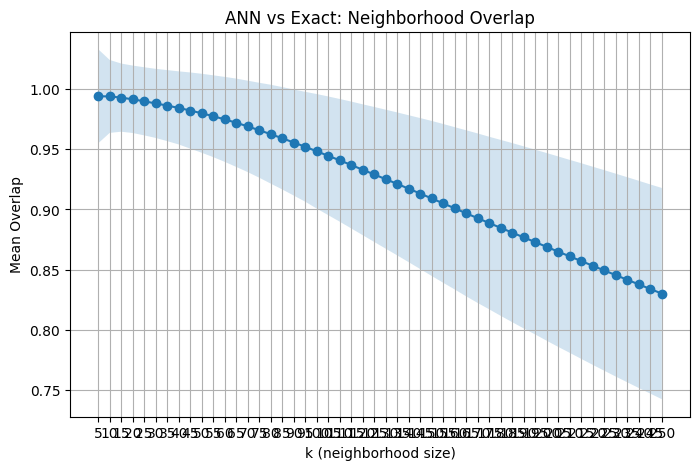

In [ ]:
# --- Plot Overlap vs k ---

ks = sorted(results.keys())
mean_overlap = [results[k]["mean_overlap"] for k in ks]
std_overlap  = [results[k]["std_overlap"]  for k in ks]

plt.figure(figsize=(8,5))
plt.plot(ks, mean_overlap, marker="o")
plt.fill_between(
    ks,
    np.array(mean_overlap) - np.array(std_overlap),
    np.array(mean_overlap) + np.array(std_overlap),
    alpha=0.2
)
plt.title("Neighborhood Overlap (Exact vs ANN)")
plt.xlabel("k (neighborhood size)")
plt.ylabel("Mean Overlap")
plt.grid(True)
plt.show()


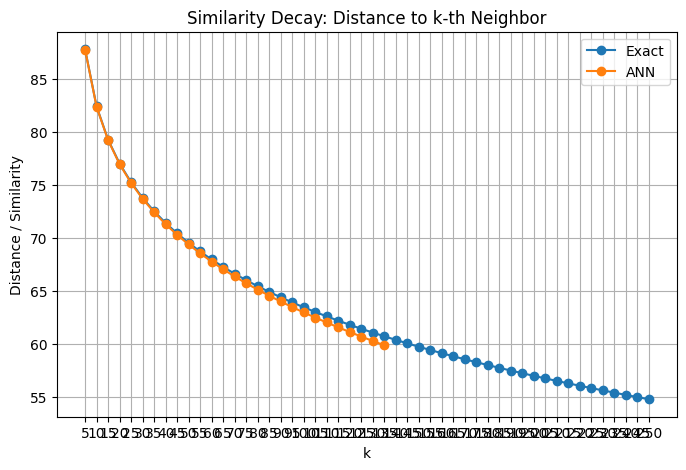

In [ ]:
# --- Plot Similarity Decay ---

sim_exact = [results[k]["similarity_k_exact"] for k in ks]
sim_ann   = [results[k]["similarity_k_ann"]   for k in ks]

plt.figure(figsize=(8,5))
plt.plot(ks, sim_exact, marker="o", label="Exact")
plt.plot(ks, sim_ann,   marker="o", label="ANN")
plt.title("Similarity Decay: k-th Neighbor Distance")
plt.xlabel("k")
plt.ylabel("Distance / Similarity")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# --- Plot LID curves ---

lid_exact = [results[k]["lid_exact_mean"] for k in ks]
lid_ann   = [results[k]["lid_ann_mean"]   for k in ks]

plt.figure(figsize=(8,5))
plt.plot(ks, lid_exact, marker="o", label="Exact LID")
plt.plot(ks, lid_ann,   marker="o", label="ANN LID")
plt.title("Local Intrinsic Dimensionality vs k")
plt.xlabel("k")
plt.ylabel("LID")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# --- Plot LID Difference ---

lid_diff = [results[k]["lid_diff_mean"] for k in ks]

plt.figure(figsize=(8,5))
plt.plot(ks, lid_diff, marker="o", color="red")
plt.title("LID Difference (ANN - Exact)")
plt.xlabel("k")
plt.ylabel("Δ LID")
plt.grid(True)
plt.show()


In [ ]:
# --- Plot Barycenter Shift ---

bary_shift = [results[k]["barycenter_shift_mean"] for k in ks]

plt.figure(figsize=(8,5))
plt.plot(ks, bary_shift, marker="o", color="purple")
plt.title("Neighborhood Barycenter Shift (Exact → ANN)")
plt.xlabel("k")
plt.ylabel("Mean Shift (L2 Norm)")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- ensure strict numeric sorting for safety ---
ks = sorted(results.keys(), key=lambda x: int(x))

# --- gather metrics in sorted order ---
mean_overlap = [results[k]["mean_overlap"] for k in ks]
std_overlap  = [results[k]["std_overlap"]  for k in ks]

sim_exact = [results[k]["similarity_k_exact"] for k in ks]
sim_ann   = [results[k]["similarity_k_ann"]   for k in ks]

lid_exact = [results[k]["lid_exact_mean"] for k in ks]
lid_ann   = [results[k]["lid_ann_mean"]   for k in ks]
lid_diff  = [results[k]["lid_diff_mean"]  for k in ks]

bary_shift = [results[k]["barycenter_shift_mean"] for k in ks]

# --- create 2x3 panel ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
ax = axes.flatten()

# --------------------------------------------------------------------
# Panel A — Overlap
# --------------------------------------------------------------------
ax[0].plot(ks, mean_overlap, marker="o")
ax[0].fill_between(
    ks,
    np.array(mean_overlap) - np.array(std_overlap),
    np.array(mean_overlap) + np.array(std_overlap),
    alpha=0.2
)
ax[0].set_title("A. Neighborhood Overlap (Exact vs ANN)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Mean Overlap")
ax[0].grid(True)

# --------------------------------------------------------------------
# Panel B — Similarity Decay
# --------------------------------------------------------------------
ax[1].plot(ks, sim_exact, marker="o", label="Exact")
ax[1].plot(ks, sim_ann,   marker="o", label="ANN")
ax[1].set_title("B. Similarity Decay (k-th Neighbor Distance)")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Distance / Similarity")
ax[1].legend()
ax[1].grid(True)

# --------------------------------------------------------------------
# Panel C — LID Exact vs ANN
# --------------------------------------------------------------------
ax[2].plot(ks, lid_exact, marker="o", label="Exact LID")
ax[2].plot(ks, lid_ann,   marker="o", label="ANN LID")
ax[2].set_title("C. Local Intrinsic Dimensionality")
ax[2].set_xlabel("k")
ax[2].set_ylabel("LID")
ax[2].legend()
ax[2].grid(True)

# --------------------------------------------------------------------
# Panel D — LID Difference
# --------------------------------------------------------------------
ax[3].plot(ks, lid_diff, marker="o", color="red")
ax[3].set_title("D. LID Distortion (ANN - Exact)")
ax[3].set_xlabel("k")
ax[3].set_ylabel("Δ LID")
ax[3].grid(True)

# --------------------------------------------------------------------
# Panel E — Barycenter Shift
# --------------------------------------------------------------------
ax[4].plot(ks, bary_shift, marker="o", color="purple")
ax[4].set_title("E. Neighborhood Barycenter Shift")
ax[4].set_xlabel("k")
ax[4].set_ylabel("Mean Shift (L2 Norm)")
ax[4].grid(True)

# --------------------------------------------------------------------
# Panel F — Blank (placeholder)
# --------------------------------------------------------------------
ax[5].axis("off")
ax[5].text(
    0.5, 0.5,
    "F. Summary Panel\n(add notes or metrics here)",
    ha='center', va='center', fontsize=14
)

plt.tight_layout()
plt.show()
